# Modeling the Data #
We will start modeling the data to find the best statistical model to work with for our problem

Here are the imports to start things off with

In [13]:
# BASIC & PANDAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# SKLEARN & MODELING
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

# From https://contrib.scikit-learn.org/categorical-encoding/
import category_encoders as ce

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix # New to version 0.22.2

## Loading the Dataset ##
Since our dataset came in with a custom ID which got a little messed up during transition so let's clean that up

In [2]:
df = pd.read_csv("../CSVs/Model_Ready_Data.csv")
df.rename(columns={"Unnamed: 0":"ID"},inplace=True)
df.set_index("ID",inplace=True)
df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,AMT_APPLICATION,AMT_OLD_ANNUITY,AMT_OLD_CREDIT,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE
ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,5,179055.0,9251.775,179055.0,24.0,18.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,39,900000.0,98356.995,1035882.0,12.0,1.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,11,24282.0,5357.250,20106.0,4.0,2.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,5,675000.0,24246.000,675000.0,5.0,0.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,1,1,37,180000.0,16509.600,180000.0,24.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0,0,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,43,40455.0,6605.910,40455.0,12.0,7.0
307507,0,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,57,57595.5,10074.465,56821.5,6.0,0.0
307508,0,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,0,0,1,1,39,28912.5,5567.715,27306.0,6.0,2.0


### Modeling Setup ###
#### Baseline: Random Forest Classifier ####
We'll start by setting up the necessary X, y differentiations

In [3]:
cat_col = df[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',
               'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
               'OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE']]

num_col = df.drop(columns=cat_col)
num_col1 = num_col.drop(columns=['TARGET'])

In [4]:
cat_cols = list(cat_col)
num_cols = list(num_col1)
X_cols = cat_cols + num_cols

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [5]:
#Setting up the target value as y
X = df[X_cols]
y = df['TARGET']

#Setting up the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [6]:
#Fitting the pipeline data to the training set
rfc = RandomForestClassifier()
pipe = make_pipeline(rfc)

#Fitting the data to a pipeline and setting up the preds
pipe.fit(X_train, y_train)

train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

In [8]:
#The first metric to aim for is going to be ROC_AUC
train_score = roc_auc_score(y_train, train_preds)
test_score = roc_auc_score(y_test, test_preds)

print(f'train score: {train_score}')
print(f'test score: {test_score}')

train score: 0.9997162718116045
test score: 0.49999527798502175


It looks like the test score is only right half the time so let's do some more fiddling with the data

In [9]:
#Setup some grid parameters
grid_param = {'n_estimators': [50,100],
              'class_weight': ['balanced'],
              'criterion': ['gini','entropy'],
              'max_depth': [2,4,6]
             }

In [10]:
#Fit the parameters onto our data
grid_search = GridSearchCV(rfc, grid_param, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [11]:
#Applying better parameters to see if our score will improve at all or not.
rfc_grid = grid_search.best_estimator_
rfc_grid.fit(X_train, y_train)

train_pred2 = rfc_grid.predict_proba(X_train)[:,1]
test_pred2 = rfc_grid.predict_proba(X_test)[:,1]

train_score2 = roc_auc_score(y_train, train_pred2)
test_score2 = roc_auc_score(y_test, test_pred2)

print(f'Train Score #2: {train_score2}')
print(f'Test Score #2: {test_score2}')

Train Score #2: 0.683541405047035
Test Score #2: 0.6605493249899632


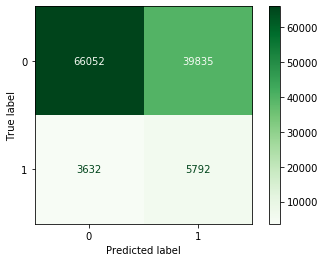

In [14]:
#See how well our model did in predicting the values
plot_confusion_matrix(rfc_grid, X_test, y_test, cmap=plt.cm.Greens, values_format='.6g')
plt.grid(False)

Feature ranking:
1. feature 18 (0.060930)
2. feature 21 (0.059918)
3. feature 20 (0.058619)
4. feature 22 (0.056471)
5. feature 15 (0.052859)
6. feature 19 (0.052430)
7. feature 40 (0.048985)
8. feature 14 (0.048540)
9. feature 41 (0.046122)
10. feature 39 (0.043939)
11. feature 13 (0.043202)
12. feature 17 (0.042147)
13. feature 43 (0.041022)
14. feature 16 (0.039549)
15. feature 32 (0.036958)
16. feature 11 (0.031614)
17. feature 42 (0.031296)
18. feature 10 (0.025565)
19. feature 9 (0.023890)
20. feature 7 (0.016058)
21. feature 29 (0.015048)
22. feature 12 (0.010807)
23. feature 4 (0.010159)
24. feature 8 (0.009209)
25. feature 6 (0.008938)
26. feature 5 (0.008110)
27. feature 3 (0.007862)
28. feature 2 (0.007250)
29. feature 27 (0.007131)
30. feature 25 (0.006911)
31. feature 1 (0.006262)
32. feature 31 (0.006062)
33. feature 30 (0.005938)
34. feature 37 (0.005336)
35. feature 38 (0.005095)
36. feature 36 (0.004702)
37. feature 28 (0.003854)
38. feature 0 (0.002824)
39. feature 34

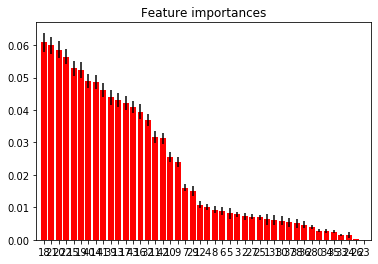

In [15]:
# Build a forest and compute the feature importances
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [18]:
df_importance = df[df.columns[[18,21,20,22,15,19,40,14,41,39,13,17,43,16,32,11,42,10,9,7]]]

In [19]:
df_importance

,DAYS_REGISTRATION,FLAG_MOBIL,SK_ID_CURR,FLAG_EMP_PHONE,REGION_POPULATION_RELATIVE,DAYS_ID_PUBLISH,AMT_APPLICATION,NAME_HOUSING_TYPE,AMT_OLD_ANNUITY,ORGANIZATION_TYPE,NAME_FAMILY_STATUS,DAYS_EMPLOYED,CNT_INSTALMENT,DAYS_BIRTH,HOUR_APPR_PROCESS_START,NAME_INCOME_TYPE,AMT_OLD_CREDIT,NAME_TYPE_SUITE,AMT_GOODS_PRICE,AMT_CREDIT
ID,,,,,,,,,,,,,,,,,,,,
0,0.852140,0.0,0.000000,1.0,0.256321,0.705433,0.030608,1,0.031863,5,3,0.045086,0.323944,0.888663,0.434783,7,0.043626,6,0.082045,0.092450
1,0.951929,0.0,0.000003,1.0,0.045016,0.959566,0.153846,1,0.338744,39,1,0.043648,0.154930,0.476287,0.478261,4,0.252386,1,0.287753,0.319206
2,0.827335,0.0,0.000006,1.0,0.134897,0.648326,0.004151,1,0.018450,11,3,0.046161,0.042254,0.347505,0.391304,7,0.004899,6,0.024970,0.023010
3,0.601451,0.0,0.000011,1.0,0.107023,0.661387,0.115385,1,0.083504,5,0,0.038817,0.056338,0.349819,0.739130,7,0.164460,6,0.067776,0.068439
4,0.825268,0.0,0.000014,1.0,0.392880,0.519522,0.030769,1,0.056859,37,3,0.038820,0.323944,0.297482,0.478261,7,0.043856,6,0.124851,0.119654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.657263,0.0,0.999989,1.0,0.446855,0.724607,0.006915,5,0.022751,43,2,0.046133,0.154930,0.896229,0.652174,7,0.009857,6,0.048751,0.053614
307507,0.822147,0.0,0.999992,0.0,0.344429,0.431708,0.009845,1,0.034697,57,5,1.000000,0.070423,0.249887,0.347826,3,0.013844,6,0.048751,0.057411
307508,0.726937,0.0,0.999994,1.0,0.065247,0.284424,0.004942,1,0.019175,39,2,0.026076,0.070423,0.577857,0.391304,7,0.006653,6,0.143876,0.161754
